<a href="https://colab.research.google.com/github/Divyanshu-ISM/Machine-Learning-Deep-Learning/blob/main/MultiVariate_TimeSeries_AppliancesDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['style'] = 'default'

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv',index_col=0,parse_dates=True)

In [3]:
df.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.7900,19.79,44.73,19.0,45.566667,17.166667,55.2,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.7225,19.79,44.79,19.0,45.992500,17.166667,55.2,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195


In [5]:
cols = ['Appliances', 'lights','T_out', 'RH_1', 'Visibility']

df = df[cols]

In [6]:
df.head()

,Appliances,lights,T_out,RH_1,Visibility
date,,,,,
2016-01-11 17:00:00,60,30,6.600000,47.596667,63.000000
2016-01-11 17:10:00,60,30,6.483333,46.693333,59.166667
2016-01-11 17:20:00,50,30,6.366667,46.300000,55.333333
2016-01-11 17:30:00,50,40,6.250000,46.066667,51.500000
2016-01-11 17:40:00,60,40,6.133333,46.333333,47.666667


In [10]:
len(df)*0.80

15788.0

Data is collected every 10 mins.

## Train-Test Split.

In [13]:
df_train = df.iloc[:15800, :]
df_test = df.iloc[15800: , :]

In [14]:
df_train.shape , df_test.shape

((15800, 5), (3935, 5))

## Data Scaling.

In [16]:
scaler = MinMaxScaler()

In [17]:
df_train_scaled_values = scaler.fit_transform(df_train)

df_train_scaled = pd.DataFrame(data = df_train_scaled_values , index = df_train.index , columns = df_train.columns)

In [18]:
df_test_scaled_values = scaler.transform(df_test)

df_test_scaled = pd.DataFrame(data = df_test_scaled_values , index = df_test.index , columns = df_test.columns)

# Creating Batches

In [19]:
output_column = 'Appliances'

In [15]:
def batcher(look_up_time_steps,df,output_column):

  l = look_up_time_steps

  X = df.drop(output_column,axis=1)
  y = df[output_column]

  X_ = []
  y_ = []

  for i in range(l,len(df)):

    batchX = X.iloc[i-l:i,:]
    X_.append(batchX)

    batchY = y.iloc[i]
    y_.append(batchY)

  X_ = np.array(X_)
  y_ = np.array(y_)

  return X_,y_

In [20]:
X_train_scaled , y_train_scaled = batcher(520 , df_train_scaled , output_column)

In [21]:
X_test_scaled , y_test_scaled = batcher(520 , df_test_scaled , output_column)

# Model Architecture

In [22]:
X_train_scaled.shape

(15280, 520, 4)

In [23]:
input_shape = (X_train_scaled.shape[1],X_train_scaled.shape[2])

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout , LeakyReLU

In [30]:
model = Sequential()

model.add(LSTM(128, input_shape= input_shape, return_sequences=True))
model.add(LeakyReLU(alpha=0.45))

model.add(LSTM(128,  return_sequences=True))
model.add(LeakyReLU(alpha=0.45))
model.add(Dropout(0.4))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))



Compile the model.

In [31]:
model.compile(optimizer='adam' , loss='mse')

Fit the model.

In [33]:
model.fit(X_train_scaled , y_train_scaled , batch_size=32 , epochs = 50 , shuffle=False)

Epoch 1/50
478/478 [==============================] - 37s 58ms/step - loss: 0.0120
Epoch 2/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0112
Epoch 3/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0111
Epoch 4/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0110
Epoch 5/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0105
Epoch 6/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0104
Epoch 7/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0104
Epoch 8/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0102
Epoch 9/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0102
Epoch 10/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0102
Epoch 11/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0102
Epoch 12/50
478/478 [==============================] - 27s 57ms/step - loss: 0.0102
E

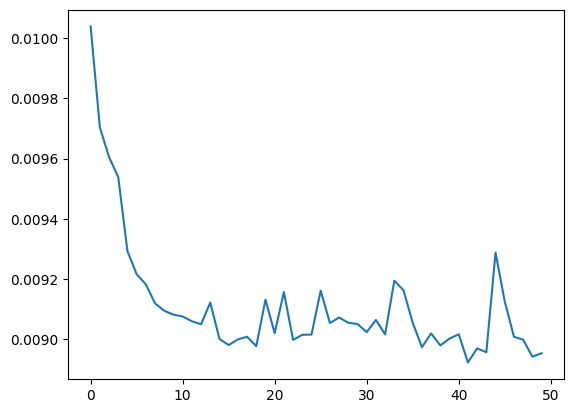

In [37]:
plt.style.use('default')
losses = model.history.history['loss']
plt.plot(range(len(losses)), losses)

# Making Final Test DataFrame

In [38]:
last_section = df_train_scaled.iloc[-520:,:]

final_test_df = last_section.append(df_test_scaled)

In [42]:
X_test_scaled, y_test_scaled = batcher(520,final_test_df , output_column)

# Predictions.

In [43]:
yp_test_scaled = model.predict(X_test_scaled)

In [45]:
len(yp_test_scaled) , len(y_test_scaled)

(3935, 3935)

#Back-Scaling to original.

In [47]:
c = scaler.scale_[0]

In [60]:
scaler.scale_

array([0.00093458, 0.01428571, 0.04048583, 0.02806886, 0.01538462])

In [48]:
yp , y_test = yp_test_scaled/c , y_test_scaled/c

In [51]:
t_test = final_test_df.index[520:]

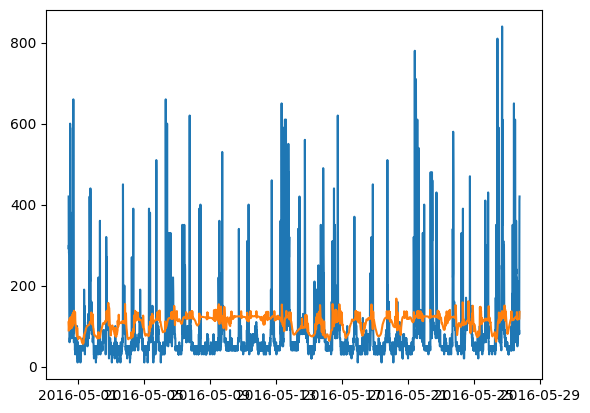

In [53]:
plt.plot(t_test,y_test)
plt.plot(t_test , yp)

In [54]:
yp_train = model.predict(X_train_scaled)/c
y_train = y_train_scaled/c

In [55]:
t_train = df_train.index[:-520]

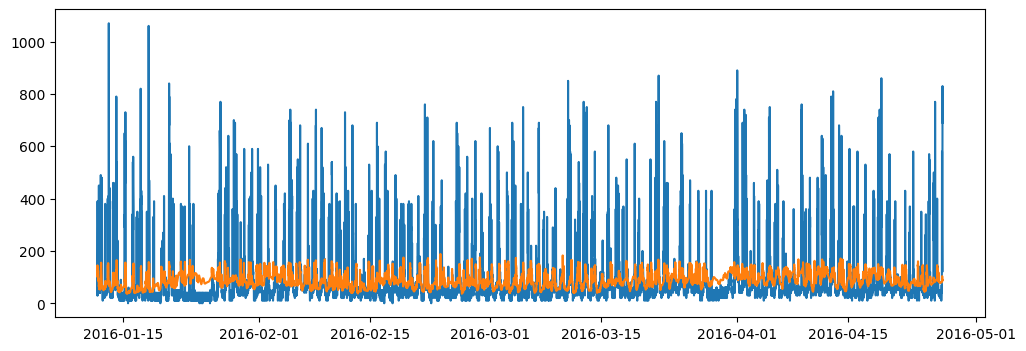

In [59]:
plt.figure(figsize=(12,4))
plt.plot(t_train,y_train)
plt.plot(t_train,yp_train)

In [2]:
# model.predict(X_train)